In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load CIFAR-10 dataset

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixels (0–255 → 0–1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten images for dense NN (32x32x3 → 3072 features)
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#  Build model function

In [6]:

def build_model(dropout=False, l2_reg=False):
    model = Sequential()
    reg = l2(1e-4) if l2_reg else None
    
    model.add(Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(3072,)))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu", kernel_regularizer=reg))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu", kernel_regularizer=reg))
    model.add(Dense(10, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model



# Training configs

In [7]:

epochs = 30
batch_size = 128

experiments = {
    "baseline": {"dropout": False, "l2": False, "early": False},
    "dropout": {"dropout": True, "l2": False, "early": False},
    "dropout+early": {"dropout": True, "l2": False, "early": True},
    "dropout+L2": {"dropout": True, "l2": True, "early": False},
}

histories = {}
results = {}

# Run experiments

In [8]:

for name, cfg in experiments.items():
    print(f"\n🔹 Training {name} model...")
    model = build_model(dropout=cfg["dropout"], l2_reg=cfg["l2"])
    
    callbacks = []
    if cfg["early"]:
        callbacks.append(EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True))
    
    start = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )
    end = time.time()
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    
    histories[name] = history
    results[name] = {"val_acc": max(history.history["val_accuracy"]),
                     "test_acc": test_acc,
                     "time": round(end-start,2),
                     "epochs": len(history.history["loss"])}


🔹 Training baseline model...


C:\Users\bbuser\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔹 Training dropout model...

🔹 Training dropout+early model...

🔹 Training dropout+L2 model...


# Print results

In [11]:

import pandas as pd
results_df = pd.DataFrame(results).T
print("\n📊 Results Summary:")
print(results_df)



📊 Results Summary:
               val_acc  test_acc    time  epochs
baseline        0.5161    0.5017  566.50    30.0
dropout         0.3600    0.3479  616.34    30.0
dropout+early   0.3081    0.3011  117.06     6.0
dropout+L2      0.3317    0.2980  590.19    30.0


# Plot curves

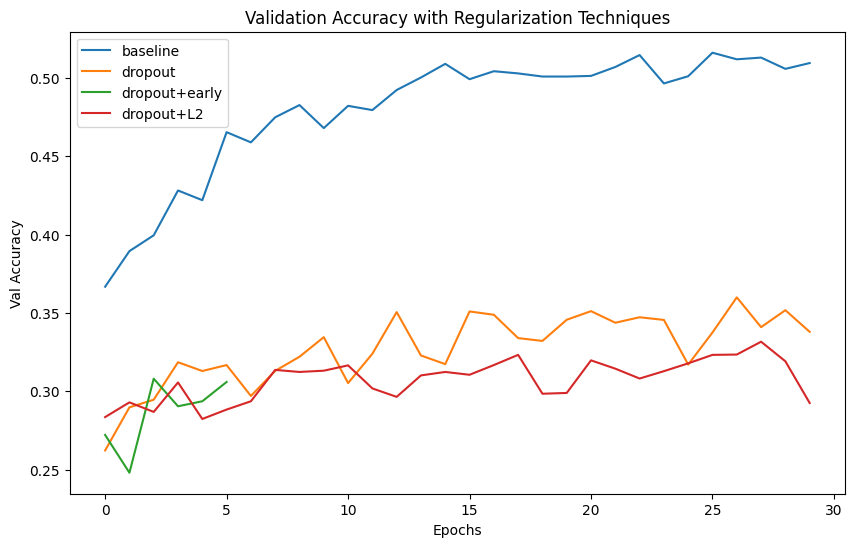

In [12]:
plt.figure(figsize=(10,6))
for name, history in histories.items():
    plt.plot(history.history["val_accuracy"], label=name)
plt.title("Validation Accuracy with Regularization Techniques")
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()